In [1]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn
from sklearn.cluster import KMeans

#Patterns Mining
from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")

import utils

In [2]:
# # Config for House Prices Dataset
# is_dataset_labeled = True  # True / False
# label_name = 'SalePrice'  # Leave empty if dataset is not labeled
# label_type = 'Continuous' # Continuous / Categorical

# ordinal_textual_columns = []  # Leave empty if dataset is labeled

# # Config for Customer Personality Analysis Dataset
# is_dataset_labeled = False  # True / False
# label_name = 'label'
# label_type = '' # Continuous / Categorical, Leave empty if dataset is not labeled

# ordinal_textual_columns = [] 
# columns_to_drop = ['custcat'] # Columns hard to deal with

# Config for Adult Income Dataset
is_dataset_labeled = True  # True / False
label_name = 'income'
label_type = 'Categorical' # Continuous / Categorical, Leave empty if dataset is not labeled

ordinal_textual_columns = ['education'] 


### 1. Load Dataset

In [3]:
dataset_path = "./datasets/adultincome/adult.csv"
dtf = pd.read_csv(dataset_path)

In [4]:
dtf

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


##### Notice
To later run the Apriori algorithm in reasonable time, we will focus only on the following prominent columns, similar to the hands-on demonstration we saw in class.

In [5]:
good_columns = ['age', 'workclass', 'education', 'educational-num', 'marital-status', 'race', 'gender','hours-per-week', 'income']
dtf = dtf[good_columns]


classify dataset columns:

In [6]:
numeric_columns, very_numerical, categorical_columns, ordinals = utils.classify_columns(dtf)
# Removing ordinal textual columns that were set at configuration, because they are also detected as categorical (they are also textual)
categorical_columns = set(categorical_columns) - set(ordinal_textual_columns)

**Data Preparing:**

* **Very numerical columns** - filling Null values with the column's mean

* **Categorical columns** - dropping those whose more than 70% of values are missing, and filling a new 'na' category in the columns that are kept

In [7]:
# the data_preparing function also returns the set of categorical columns that weren't dropped
dtf, categorical_columns = utils.data_preparing(dtf, very_numerical, categorical_columns)

In [8]:
dtf

,age,workclass,education,educational-num,marital-status,race,gender,hours-per-week,income
0,25,Private,11th,7,Never-married,Black,Male,40,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,White,Male,50,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,White,Male,40,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Black,Male,40,>50K
4,18,?,Some-college,10,Never-married,White,Female,30,<=50K
...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,White,Female,38,<=50K
48838,40,Private,HS-grad,9,Married-civ-spouse,White,Male,40,>50K
48839,58,Private,HS-grad,9,Widowed,White,Female,40,<=50K
48840,22,Private,HS-grad,9,Never-married,White,Male,20,<=50K


### 2. 1. For labeled datasets - binning / encoding the label

In [9]:
# Binning countinuous labels
if is_dataset_labeled and label_type == 'Continuous':
    # Binning the label column, if there exists one
    dtf[label_name] = pd.qcut(dtf[label_name],5,labels=["0", "1", "2", "3", "4"])
    dtf[label_name].value_counts()

# Label Encoding categorical labels
elif is_dataset_labeled and label_type == 'Categorical': 
    label_encoder = sklearn.preprocessing.LabelEncoder()
    # Encode labels in column
    dtf[label_name] = label_encoder.fit_transform(dtf[label_name])

In [10]:
dtf

,age,workclass,education,educational-num,marital-status,race,gender,hours-per-week,income
0,25,Private,11th,7,Never-married,Black,Male,40,0
1,38,Private,HS-grad,9,Married-civ-spouse,White,Male,50,0
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,White,Male,40,1
3,44,Private,Some-college,10,Married-civ-spouse,Black,Male,40,1
4,18,?,Some-college,10,Never-married,White,Female,30,0
...,...,...,...,...,...,...,...,...,...
48837,27,Private,Assoc-acdm,12,Married-civ-spouse,White,Female,38,0
48838,40,Private,HS-grad,9,Married-civ-spouse,White,Male,40,1
48839,58,Private,HS-grad,9,Widowed,White,Female,40,0
48840,22,Private,HS-grad,9,Never-married,White,Male,20,0


### 2.2. For unlabeled datasets - run KMeans for classification

We first have to make sure all the values in the dataset are numerical. To do so, we one hot encode the categorical columns, and label encode the ordinal columns that do not contain numerical values (e.g. Country, City) - if there are any. We need to define that by hand because we don't have an easy way to distinguish between textual categorical columns and textual ordinal columns.

In [11]:
if not is_dataset_labeled:

    modified_dtf = dtf.copy(deep=True)
    
    # Label Encoding ordinal textual columns
    modified_dtf = utils.label_encoding(dtf, ordinal_textual_columns)
    
    # One-hot encoding the categorical columns
    modified_dtf = utils.one_hot_encoding(dtf, categorical_columns)
    
    modified_dtf
    

In [12]:
if not is_dataset_labeled:
    modified_dtf

#### Running KMeans Classifier on the modified dataset

In [13]:
if not is_dataset_labeled:
    dtf[label_name] = utils.run_KMeans(modified_dtf, k=10)
    dtf[label_name].value_counts()

Removing samples from small clusters (clusters whose size is less than 1% of the dataset's size)

In [14]:
if not is_dataset_labeled:
    labels_to_remove = list()
    one_percentile = (int) (dtf.shape[0] / 100)
    for val, count in dtf.labels.value_counts().iteritems():
        if count <= one_percentile:
            labels_to_remove.append(val)

    # Remove outlier samples that are in small clusters
    df1 = dtf[~dtf.labels.isin(labels_to_remove)]


In [15]:
if not is_dataset_labeled:
    dtf[label_name].value_counts()

### 3. Running Apriori Algorithm
We now have a labeled dataset. We split it into clusters according to the label, and convert each cluster dataframe into a transactional form.  
Then, we run the Apriori algorithm on each dataframe independently, and save the total list of mined association rules.

In [16]:
%%time
cluster_mined_rules = utils.mine_labeled_df_association_rules(dtf, label_name, min_support=0.5, min_confidence=0.8)

Wall time: 959 ms


In [17]:
cluster_mined_rules[:5]

[{('gender', 'Male')} -> {('income', 0)},
 {('gender', 'Male')} -> {('race', 'White')},
 {('race', 'White')} -> {('income', 0)},
 {('income', 0)} -> {('race', 'White')},
 {('workclass', 'Private')} -> {('income', 0)}]

In [18]:
len(cluster_mined_rules)

68

### Experimental Evaluation
We will now try to show that the rules we mined from the clusters are more insightful than rules that are mined on the dataset as a whole.

In [19]:
unpartitioned_dataset_rules = utils.mine_association_rules(dtf, min_support=0.5, min_confidence=0.8)

In [20]:
unpartitioned_dataset_rules

[{('gender', 'Male')} -> {('race', 'White')},
 {('income', 0)} -> {('race', 'White')},
 {('workclass', 'Private')} -> {('race', 'White')}]

We can see that when using the same support and confidence thresholds, we get way more association rules when we mine them independently from each cluster.

In [21]:
print("Simple mined rules:  ", len(unpartitioned_dataset_rules))
print("Cluster mined rules: ", len(cluster_mined_rules))

Simple mined rules:   3
Cluster mined rules:  68


to get the around the same number of rules as the rules we mined from clusters, the support / confidence thresholds (or both) need to be lowered.

In [22]:
more_unpartitioned_dataset_rules = utils.mine_association_rules(dtf, min_support=0.29, min_confidence=0.4)

In [23]:
len(more_unpartitioned_dataset_rules)

65

#### Plot Amounts of Association Rules

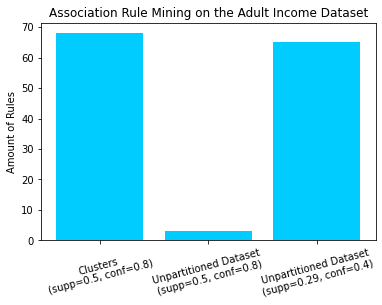

In [24]:
height = [len(cluster_mined_rules), len(unpartitioned_dataset_rules) ,len(more_unpartitioned_dataset_rules)]
bars = ('Clusters\n(supp=0.5, conf=0.8)',
        'Unpartitioned Dataset\n(supp=0.5, conf=0.8)',
        'Unpartitioned Dataset\n(supp=0.29, conf=0.4)')
 
# Create bars and choose color
plt.bar([1,2,3], height, color = (0,0.8,1,1))
 
# Add title and axis names
plt.title('Association Rule Mining on the Adult Income Dataset')
# plt.xlabel('categories')
plt.ylabel('Amount of Rules')
 
# Create names on the x axis
plt.xticks([1,2,3], bars, rotation=15)
 
# Show graph
plt.show()


We expect to see higher number of interesting rules among the rules we mined from each cluster independently.  


##### Lift

The Lift measure on an association rule X->Y measures how many times more often X and Y occur together than expected if they were statistically independent.  
The range of lift value is [0, inf].

* A lift value of 1 indicates independece between X and Y.
* Lift(X->Y)<1 means negative correlation between X and Y.
* Lift(X->Y)>1 means strong dependancy between X and Y.

Therefore, we will check how many rules are interesting - not close to 1:


In [29]:
count_interesting_cluster_rules_lift = 0
count_interesting_unpartitioned_rules_lift = 0

epsilon = 0.05

for rule in cluster_mined_rules:
    if rule.lift >= 1 + epsilon or rule.lift <= 1 - epsilon:
        count_interesting_cluster_rules_lift += 1
        
for rule in more_unpartitioned_dataset_rules:
    if rule.lift >= 1 + epsilon or rule.lift <= 1 - epsilon:
        count_interesting_unpartitioned_rules_lift += 1

print(count_interesting_cluster_rules_lift)
print(count_interesting_unpartitioned_rules_lift)

6
28


##### Conviction

In [30]:
count_interesting_cluster_rules_conv = 0
count_interesting_unpartitioned_rules_conv = 0

epsilon = 0.05

for rule in cluster_mined_rules:
    if rule.conviction >= 1 + epsilon or rule.conviction <= 1 - epsilon:
        count_interesting_cluster_rules_conv += 1
        
for rule in more_unpartitioned_dataset_rules:
    if rule.conviction >= 1 + epsilon or rule.conviction <= 1 - epsilon:
        count_interesting_unpartitioned_rules_conv += 1

print(count_interesting_cluster_rules_conv)
print(count_interesting_unpartitioned_rules_conv)

46
40


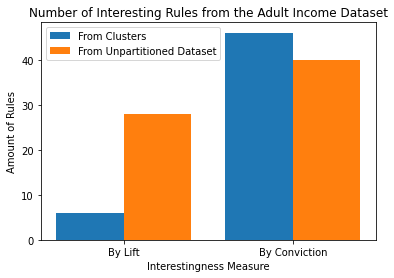

In [31]:
X = ['By Lift','By Conviction']
from_cluster = [count_interesting_cluster_rules_lift, count_interesting_cluster_rules_conv]
from_unpartitioned = [count_interesting_unpartitioned_rules_lift, count_interesting_unpartitioned_rules_conv]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, from_cluster, 0.4, label = 'From Clusters')
plt.bar(X_axis + 0.2, from_unpartitioned, 0.4, label = 'From Unpartitioned Dataset')
  
plt.xticks(X_axis, X)
plt.xlabel("Interestingness Measure")
plt.ylabel("Amount of Rules")
plt.title("Number of Interesting Rules from the Adult Income Dataset")
plt.legend()
plt.show()

Measuring the lift and conviction values, probably isn't the best way to measure the interestingness level of rule for our purpose. Maybe becuase the lift calculation depends on the support and confidence, and doens't do justice with the rare rules we mined from each cluster independently.  

For future work we will try to check their interestingness in another way - we will take the test dataset, and label it using KNN classifier according to the clusters.
Then, we will randomly remove one cell from every sample, and see how well rules from the sample's cluster restore the missing value.